# 1. EEG Dataset Processing

## Run in Several Sections

- 1a EEG Dataset Load & Preprocessing [Jump To](#run-1a-eeg-dataset-load--preprocessing)
- 1b EEG Feature Extraction [Jump To](#run-1b-eeg-feature-extraction)
- 1c EEG Results Collation [Jump To](#run-1c-eeg-results-collation)




## Some Ref Links

- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io
- MNE-Python: https://mne.tools/stable/index.html
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- autoreject = 0.4.3
- specparam = 2.0.0rc3

# Imports & Utilities

In [1]:
# General imports
import os
import sys
import gc
import warnings

from datetime import datetime
from pprint import pprint
import time
import pickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from autoreject import AutoReject
from autoreject import get_rejection_threshold

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra
# from specparam import __version__ as specparam_version
# print('Current SpecParam version:', specparam_version)


# Functions

## Raw EEG Load, Filtering Functions

In [2]:
# Function to get the raw EEG signal data
#

def get_EEG_raw(dataset_path, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    dataset_path : str
    subject_id : str

    Returns
    -------
    EEG_raw : FIF
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # Cater for none or multiple sessions, eg 'ses-01', 'ses-02'
    temp_path = os.path.join(dataset_path, subject)
    subfolders = [f for f in os.listdir(temp_path) if os.path.isdir(os.path.join(temp_path, f))]
    if 'eeg' in subfolders:
        session = ''
    elif any(f.startswith('ses-') for f in subfolders):
        session = sorted([f for f in subfolders if f.startswith('ses-')])
    else:
        raise FileNotFoundError(f"No 'eeg' or session folder found in {temp_path}")
    
    # Cater for 0 or multiple sessions
    # print(f'Test Found: {session}')
    sessions_eeg_raw = []
    if session == '':
        temp_path = os.path.join(dataset_path, subject, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
                for warn in w:
                    print(f"Warning loading EEG data for subject {subject}: {warn.message}")
                    if eeg_dataset_raw.annotations is not None:
                        print('Removing Annotations')
                        boundary_idx = []
                        for i, desc in enumerate(eeg_dataset_raw.annotations.description):
                            if 'boundary' in desc.lower():
                                boundary_idx.append(i)
                        if boundary_idx:
                            eeg_dataset_raw.annotations.delete(boundary_idx)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    else:
        for next_session in session:
            temp_path = os.path.join(dataset_path, subject, next_session, datatype)
            temp_file_name = subject + '_' + next_session + '_task-' + task + '_' + datatype + '.set'
            eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
            # print(f'Test session path: {eeg_lab_file_path}')
            try:
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
            except Exception as e:
                raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    
    return sessions_eeg_raw

In [3]:
# Function to plot EEG Time Series & Save to PDF
#

def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    # Time Range
    sfreq = eeg_FIF.info['sfreq']
    if time_range_s:
        start = int(time_range_s[0] * sfreq)
        stop = int(time_range_s[1] * sfreq)
    else:
        start = 0
        stop = None

    # Get signal and times for the elected channel(s)
    # Handle Epoched data
    if eeg_FIF.__class__.__name__.startswith('Raw'):
        signal, times = eeg_FIF.get_data(picks=channels, 
                                        start=start, stop=stop,
                                        return_times=True)
    else:
        warnings.warn("Epoched data detected: plotting may not be accurate for all types.", UserWarning)
        return
        # signal, times = eeg_FIF.get_data(picks=channels)
        # times = eeg_FIF.times

    # plot and copy to pdf
    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

In [4]:
# Function to save EEG data for a given subject
#

def save_EEG_for_subject(eeg_data, folder_path, subject_name, tag, epoched=False, format='fif', verbose=False):

    if epoched:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_epo.{format}')
    else:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_raw.{format}')

    if format == 'fif':
        eeg_data.save(subject_results_file, overwrite=False, verbose=verbose)
    elif format == 'set':
        mne.export.export_raw(subject_results_file, eeg_data, fmt='eeglab', overwrite=False, verbose=verbose)
    else:
        raise ValueError(f"Unsupported format: {format}")


In [5]:
# Function to filter the raw EEG signal data
#

def perform_EEG_filtering(params, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_filtered = EEG_raw.copy()

    # -----------------------------------------------------------------------
    # Bandpass filtering
    #
    EEG_filtered = EEG_filtered.filter(picks='eeg', 
                                       l_freq=params['band_pass_lf'], 
                                       h_freq=params['band_pass_hf'], 
                                       method=params['band_pass_method'], 
                                       phase='zero', 
                                       verbose=flag_verbose)

    # -----------------------------------------------------------------------
    # Montage Set
    # Attempt to use standard-1020 channels, but remove any channels not in it
    #
    std_1020_montage = mne.channels.make_standard_montage("standard_1020")
    
    # Identify missing channels & drop them
    raw_set = set(EEG_raw.ch_names)
    montage_set = set(std_1020_montage.ch_names)
    missing_in_raw = montage_set - raw_set
    missing_in_montage = raw_set - montage_set  
    EEG_filtered.drop_channels(missing_in_montage)

    # Set to standard montage and plot
    EEG_filtered.set_montage(std_1020_montage)

    # -----------------------------------------------------------------------
    # Remove linear trends from each channel signal & average
    #
    if params['linear_detrend'] != 'none':
        EEG_filtered.apply_function(sci.signal.detrend, n_jobs=-1, 
                                    channel_wise=True, 
                                    type=params['linear_detrend'], 
                                    verbose=flag_verbose)

    # Execute average referencing
    EEG_filtered.set_eeg_reference(ref_channels=params['channel_referencing'], verbose=flag_verbose)

    if flag_verbose:
        # std_1020_montage.plot()
        print(f"Channels in montage but not in EEG_raw: {sorted(missing_in_raw)}")
        print(f"Channels in EEG_raw but not in montage: {sorted(missing_in_montage)}")
        print(f"Number of channels before: {len(EEG_raw.ch_names)} and after montage set: {len(EEG_filtered.ch_names)}")
        # fig = EEG_filtered.plot_sensors(show_names=True)
        # plt.show()

    return EEG_filtered


## Artefact Removal Functions

In [6]:
# Function to perform artifact removal using ICA etc
#

def perform_artefact_removal(params, EEG_raw):
    """
    Artefact removal on the EEG raw data, using ICA

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    results : pd series
    epochs_ar : fif
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_cleaned = EEG_raw.copy()
    quality_warning = False

    # -----------------------------------------------------------------------
    # Determine ICA components, label & identify for exclusion
    #

    # ICA & filter
    ica = ICA(n_components=len(EEG_cleaned.ch_names) - 1, 
              max_iter="auto", 
              method=params['ica_method'], 
              random_state=42, 
              fit_params=dict(extended=True))
    ica.fit(EEG_cleaned, verbose=flag_verbose)
 
    ica_labels = label_components(EEG_cleaned, ica, method='iclabel')
    labels = ica_labels["labels"]
    brain_components = [i for i, label in enumerate(labels) if label == "brain"]
    other_components = [i for i, label in enumerate(labels) if label != "brain"]
    filtered_ica = ica.apply(EEG_cleaned.copy(), exclude=np.unique(other_components), verbose=flag_verbose)

    # Flag 'quality'
    ICA_rejection_level = len(other_components)/ica.n_components_
    if ICA_rejection_level >= params['ICA_rejection_threshold']:
        warnings.warn(f"High component rejection: {100 * ICA_rejection_level:.2f}% marked as non-brain.", UserWarning)
        quality_warning = True

    if flag_verbose:
        print('ICs Breakdown')
        print(f'Original Channels: {len(EEG_cleaned.ch_names)}. ICs: {ica.n_components_}')
        print(f'Brain Components: {len(brain_components)}, {100 * len(brain_components)/ica.n_components_:.2f}%')
        print(f'Other Components: {len(other_components)}, {100 * len(other_components)/ica.n_components_:.2f}%')
        print(f'List of Brain components: {brain_components}')

        # Details for non-brain ICs
        non_brain_labels = [label for label in labels if label != "brain"]
        label_counts = Counter(non_brain_labels)
        print("Non-brain IC counts:")
        for comp_type, count in label_counts.items():
            print(f"- {comp_type}: {count}")

        # Show the explained variance for top 5 components
        for component_idx in range(min(5, ica.n_components_)):
            component_variance = ica.get_explained_variance_ratio(EEG_cleaned, components=component_idx)
            print(f"Component {component_idx} contribution:", end=' ')
            for ch_type, variance in component_variance.items():
                print(f"  {ch_type}: {100 * variance:.2f}%")

        # ica.plot_overlay(EEG_cleaned, exclude=[0], picks="eeg")

    # -----------------------------------------------------------------------
    # Epoching & identify epochs for rejection
    #

    # Group the EEG signal into epochs and apply linear detrending
    epochs = mne.make_fixed_length_epochs(filtered_ica, duration=1, overlap=0, preload=True, verbose=flag_verbose)
    epochs.apply_function(sci.signal.detrend, type='linear', verbose=flag_verbose)

    # Use autoreject to identify unusual large amplitudes in each epoch, drop these
    reject_criteria = get_rejection_threshold(epochs, verbose=flag_verbose)
    epochs.drop_bad(reject=reject_criteria, verbose=False)

    # Instantiate AutoReject and clean individual segments
    epochs_ar, reject_log = ar_model.fit_transform(epochs, return_log=True)
    epochs_ar.pick(['eeg'])
    n_epochs_rejected = np.sum(reject_log.bad_epochs)
    epochs_rejection_level = n_epochs_rejected / len(epochs)
    
    if flag_verbose:
        print(f'Epochs rejected: {n_epochs_rejected} out of {len(epochs)}, {100 * epochs_rejection_level:.2f}%')
        # TODO: Are these plots really of much use?
        # Epochs plot rejection patterns
        reject_log.plot('horizontal')
        # Before and After
        epochs.average().plot() 
        epochs_ar.average().plot() 

        print('EEG Post Artifact Removal')
        print(epochs_ar)

    # -----------------------------------------------------------------------
    # Collate results
    #
    results = pd.Series({
        'EEG_processing_quality_warning': quality_warning,
        'channel_count': len(EEG_raw.ch_names),
        'ICA_components_count': ica.n_components_,
        'ICA_rejection_level': ICA_rejection_level,
        'epochs_count': len(epochs),
        'epoch_rejection_level': epochs_rejection_level
        })
    
    return results, epochs_ar


# Run: 1a EEG Dataset Load & Preprocessing

In [7]:
# Run Details & Parameters
#

# Study Details
study_name = 'IOWA_Rest'

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Run Name & Test Mode
test_mode = True
run_description = 'sample_test'

# Preprocessing Parameters for this run
preprocess_params = {'band_pass_lf': 1, 'band_pass_hf': 100, 
                     'band_pass_method': 'iir', 'phase': 'zero',
                     'linear_detrend': 'linear',  # linear, none
                     'channel_referencing': 'average' 
                     }
artefact_params = {'ica_method': 'infomax', # infomax, none
                   'ICA_rejection_threshold': 0.8
                    }

# Setup the processing run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'1a_EEG_Preprocessing_Results_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['eeg_processing_results_path'], run_name, exists_ok=False)
run_details = pd.Series({
    'run_name': run_name,
    'study_name': study_name,
    'preprocess_params': preprocess_params,
    'artefact_params': artefact_params,
})
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    test_subjects = [0,5,101]
    test_channels = ['F4', 'C5', 'Cz', 'P6']
else:
    VERBOSE = False
    test_subjects = []
    test_channels = []
    
del current_date, study_name, run_description, study_folder_path


EEG Preprocessing
- Study: IOWA_Rest ds004584-1.0.0
- Run: 1a_EEG_Preprocessing_Results_20250702_sample_test
- Preprocessing Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
- Artefact Removal Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}

-----------------------------------------------------------------------------------------------
Subject: sub-001
---Get EEG Raw Data - FIF -----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-001/eeg/sub-001_task-Rest_eeg.fdt
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Warning loading EEG data for subject sub-001: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Removing Annotations
Description: None on None
<RawEEGLAB | sub-001_task-Rest_eeg.fdt,

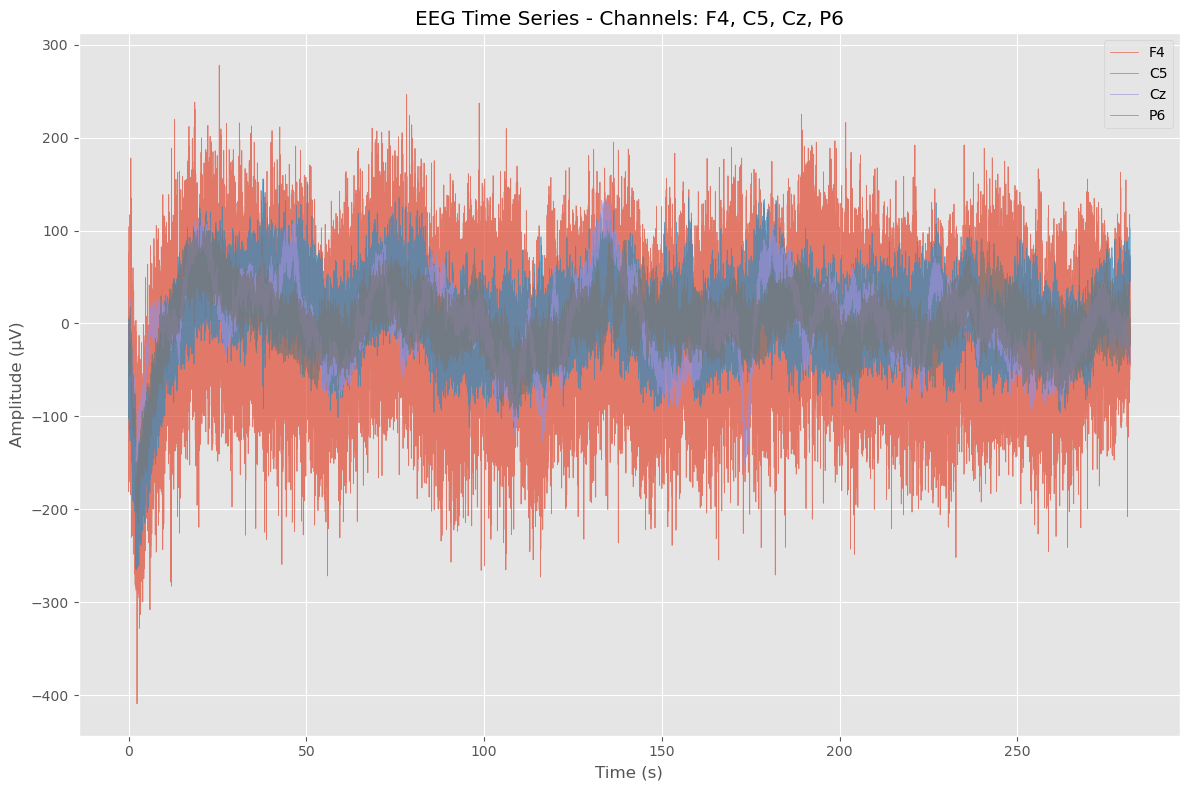

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.2s finished


Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


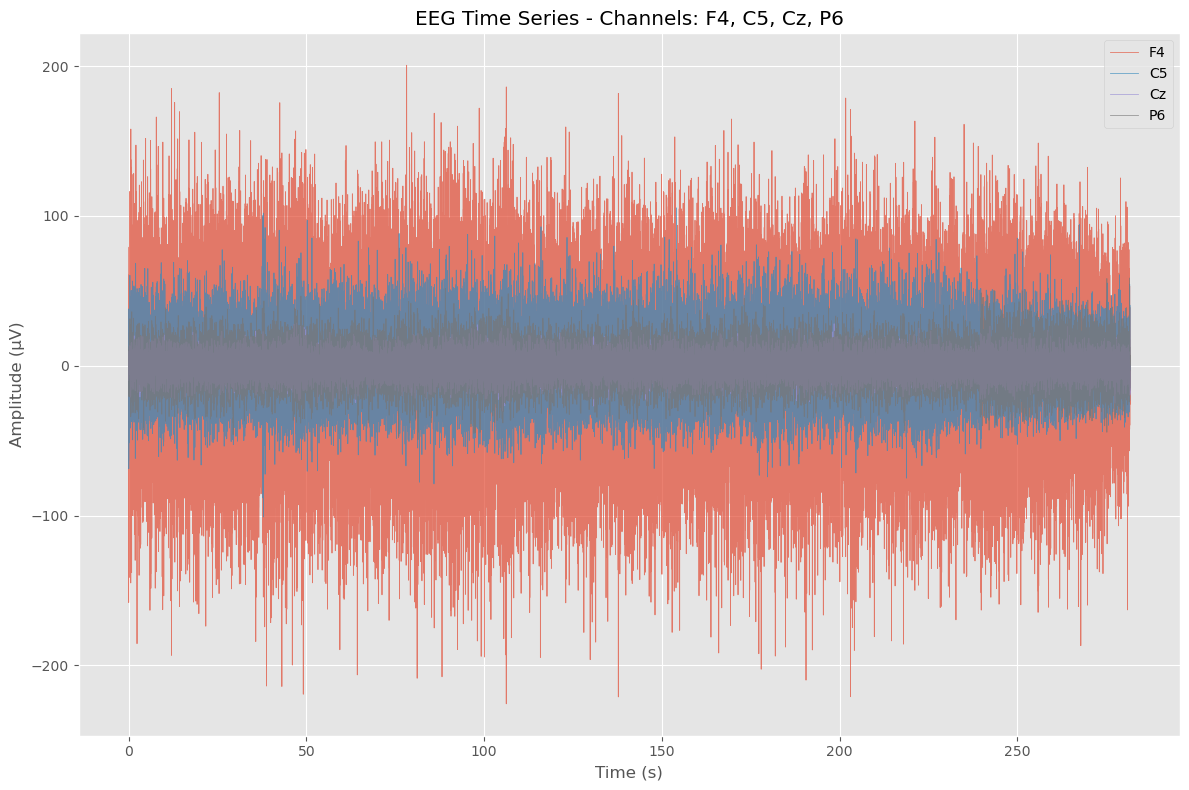

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 208.2s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 58 ICA components
    Projecting back using 63 PCA components
ICs Breakdown
Original Channels: 63. ICs: 62
Brain Components: 4, 6.45%
Other Components: 58, 93.55%
List of Brain components: [11, 12, 15, 55]
Non-brain IC counts:
- muscle artifact: 24
- eye blink: 2
- other: 27
- line noise: 3
- channel noise: 2


/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_73863/352746291.py:45: UserWarning: High component rejection: 93.55% marked as non-brain.
  warnings.warn(f"High component rejection: {100 * ICA_rejection_level:.2f}% marked as non-brain.", UserWarning)


Component 0 contribution:   eeg: 13.32%
Component 1 contribution:   eeg: 12.40%
Component 2 contribution:   eeg: 11.63%
Component 3 contribution:   eeg: 9.29%
Component 4 contribution:   eeg: 8.91%
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 281 events and 500 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=8


  0%|          | Repairing epochs : 0/281 [00:00<?,       ?it/s]

Dropped 9 epochs: 37, 80, 104, 140, 141, 142, 178, 179, 218
Epochs rejected: 9 out of 281, 3.20%


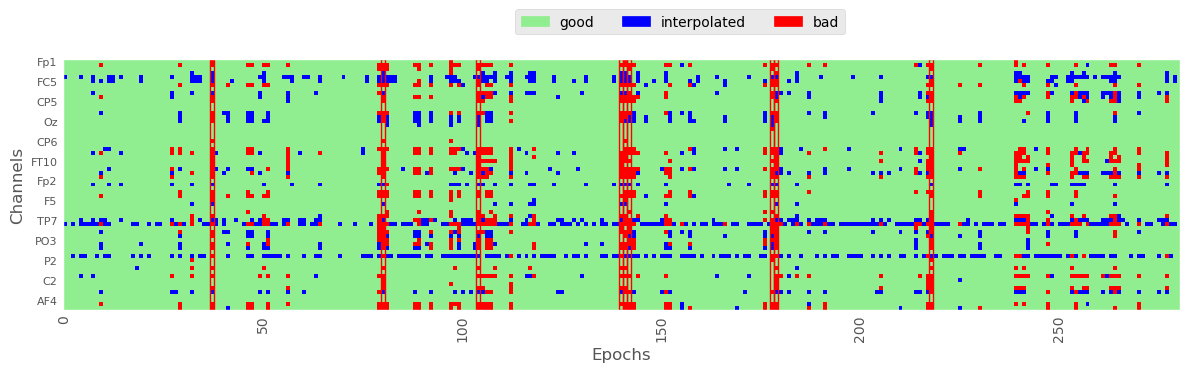

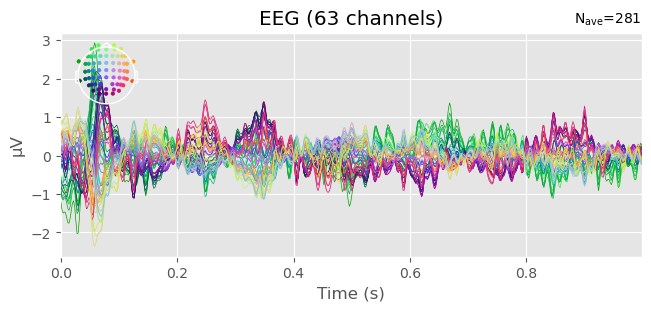

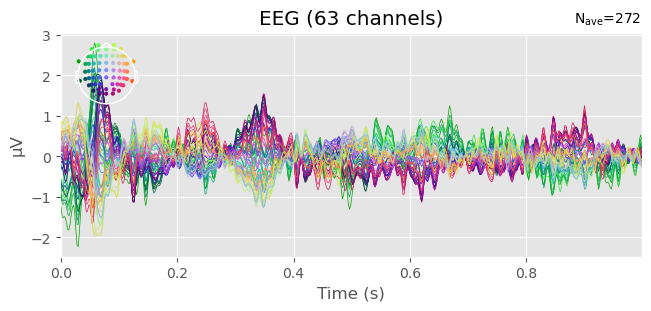

EEG Post Artifact Removal
<Epochs | 272 events (all good), 0 – 0.998 s (baseline off), ~65.4 MiB, data loaded,
 '1': 272>
Temp .... <Epochs | 272 events (all good), 0 – 0.998 s (baseline off), ~65.4 MiB, data loaded,
 '1': 272>, 
EEG_processing_quality_warning        True
channel_count                           63
ICA_components_count                    62
ICA_rejection_level               0.935484
epochs_count                           281
epoch_rejection_level             0.032028
dtype: object

-----------------------------------------------------------------------------------------------
Subject: sub-006
---Get EEG Raw Data - FIF -----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-006/eeg/sub-006_task-Rest_eeg.fdt
Reading 0 ... 131029  =      0.000 ...   262.058 secs...
Warning loading EEG data for subject sub-006: The data contains 'boundary' events, indicating data discontinuities. Be cauti

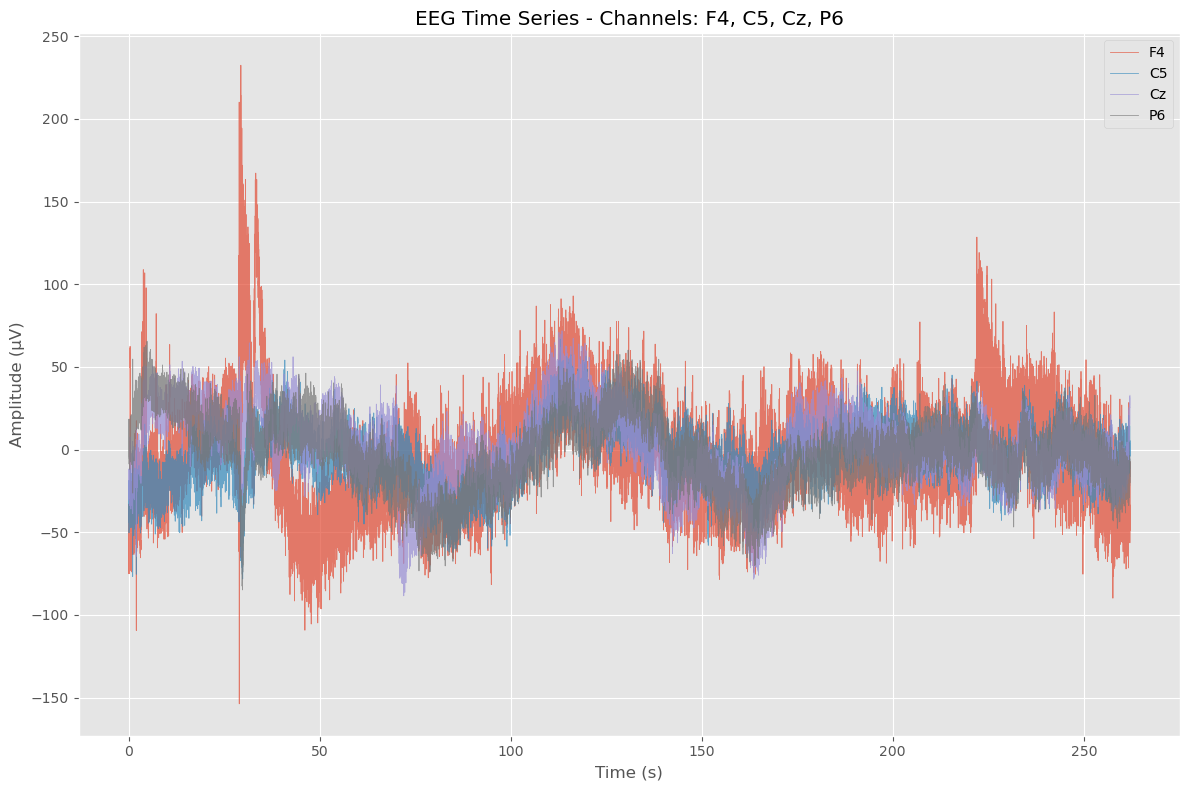

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.7s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


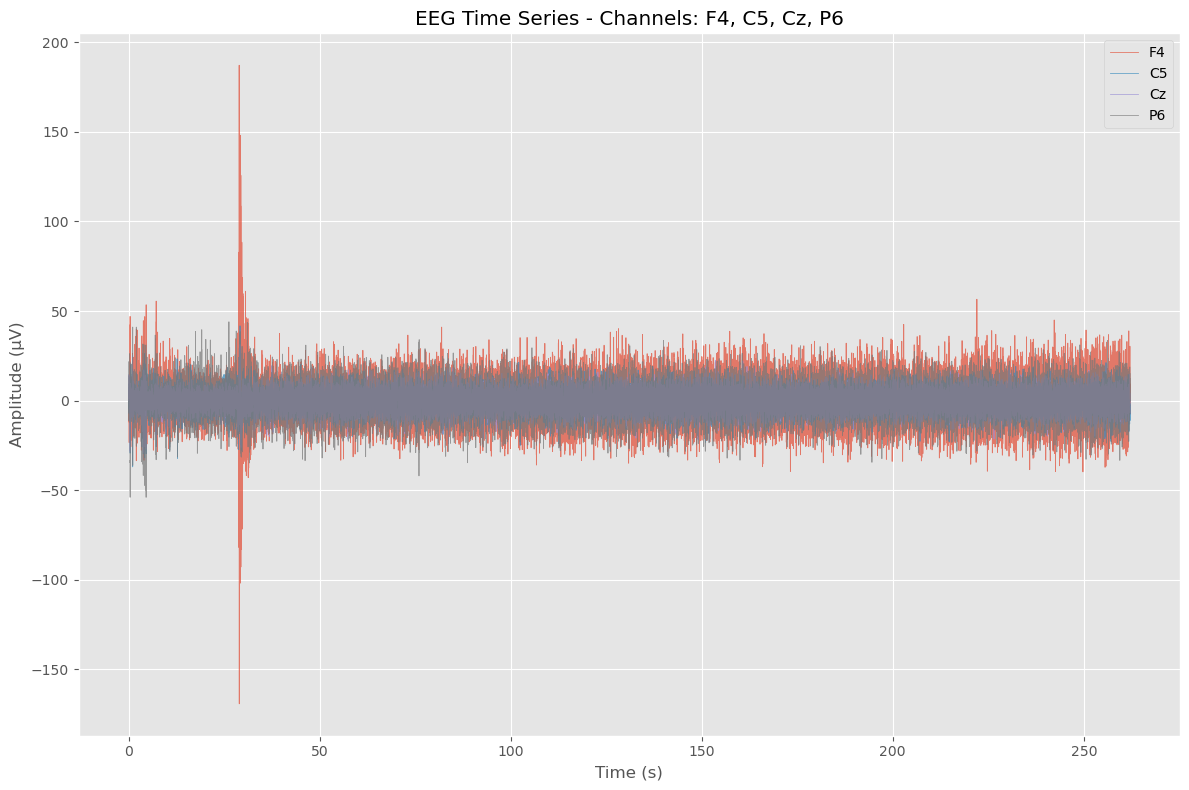

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 73.2s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 40 ICA components
    Projecting back using 63 PCA components
ICs Breakdown
Original Channels: 63. ICs: 62
Brain Components: 22, 35.48%
Other Components: 40, 64.52%
List of Brain components: [5, 6, 7, 8, 10, 12, 14, 15, 26, 28, 29, 33, 35, 38, 42, 44, 46, 47, 50, 51, 58, 61]
Non-brain IC counts:
- eye blink: 4
- other: 10
- line noise: 9
- channel noise: 2
- muscle artifact: 15
Component 0 contribution:   eeg: 22.31%
Component 1 contribution:   eeg: 19.52%
Component 2 contribution:   eeg: 6.82%
Component 3 contribution:   eeg: 6.59%
Component 4 contribution:   eeg: 5.01%
Not setting metadata
262 matching events found
No baseline correction applied
0 projection 

  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/253 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=8


  0%|          | Repairing epochs : 0/253 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Epochs rejected: 0 out of 253, 0.00%


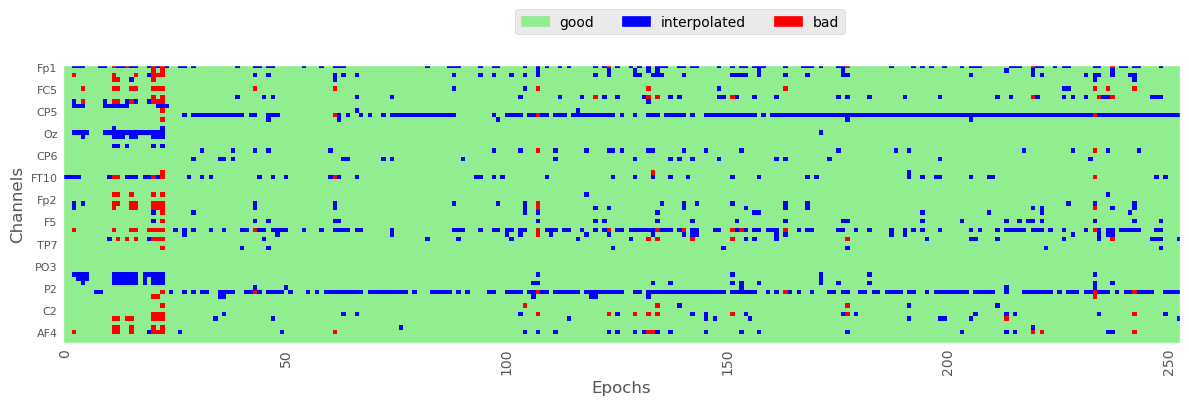

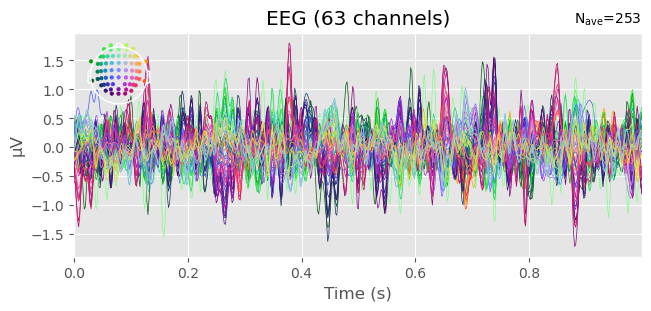

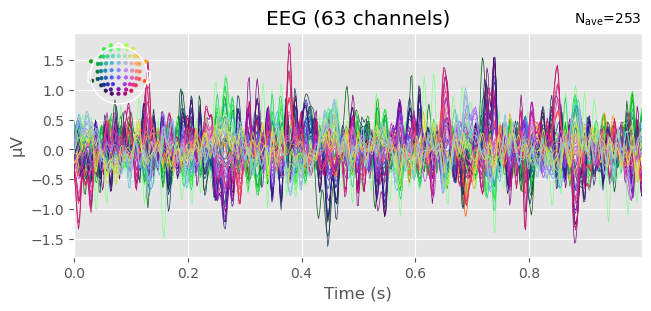

EEG Post Artifact Removal
<Epochs | 253 events (all good), 0 – 0.998 s (baseline off), ~60.9 MiB, data loaded,
 '1': 253>
Temp .... <Epochs | 253 events (all good), 0 – 0.998 s (baseline off), ~60.9 MiB, data loaded,
 '1': 253>, 
EEG_processing_quality_warning       False
channel_count                           63
ICA_components_count                    62
ICA_rejection_level               0.645161
epochs_count                           253
epoch_rejection_level                  0.0
dtype: object

-----------------------------------------------------------------------------------------------
Subject: sub-102
---Get EEG Raw Data - FIF -----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-102/eeg/sub-102_task-Rest_eeg.fdt
Reading 0 ... 105429  =      0.000 ...   210.858 secs...
Warning loading EEG data for subject sub-102: The data contains 'boundary' events, indicating data discontinuities. Be cauti

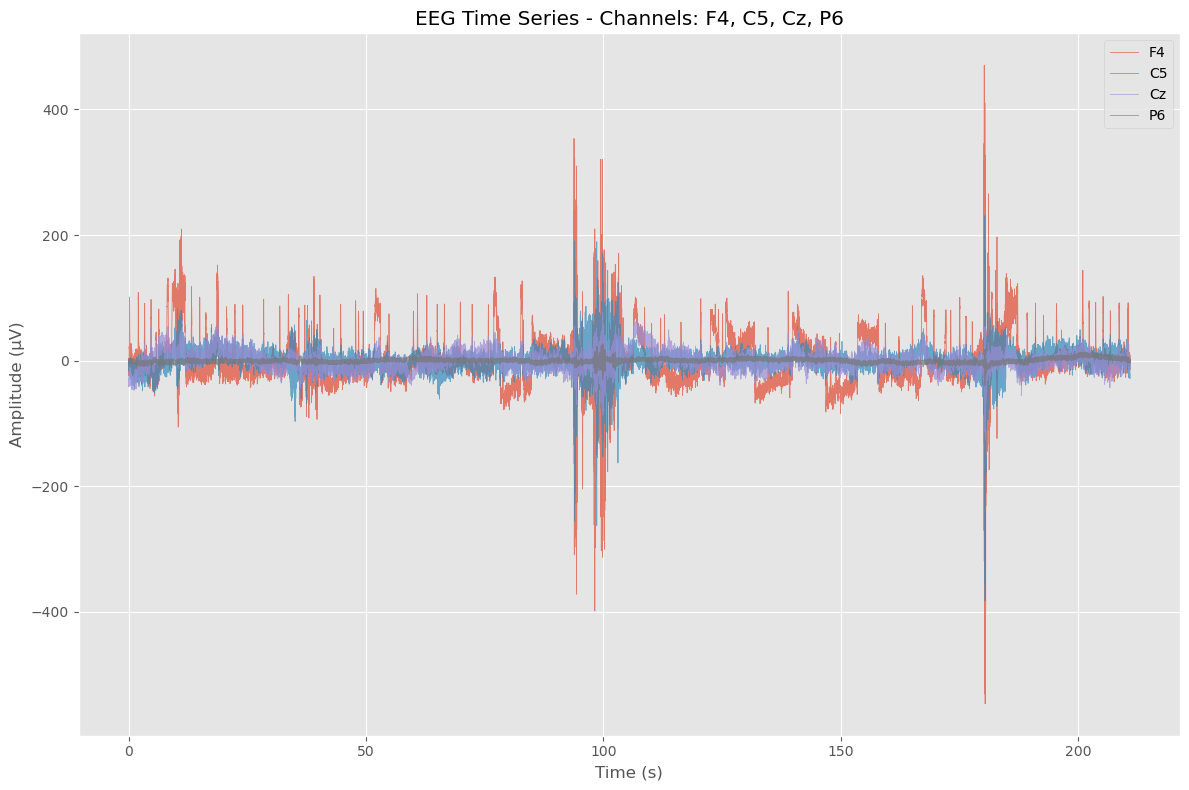

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.3s finished


Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


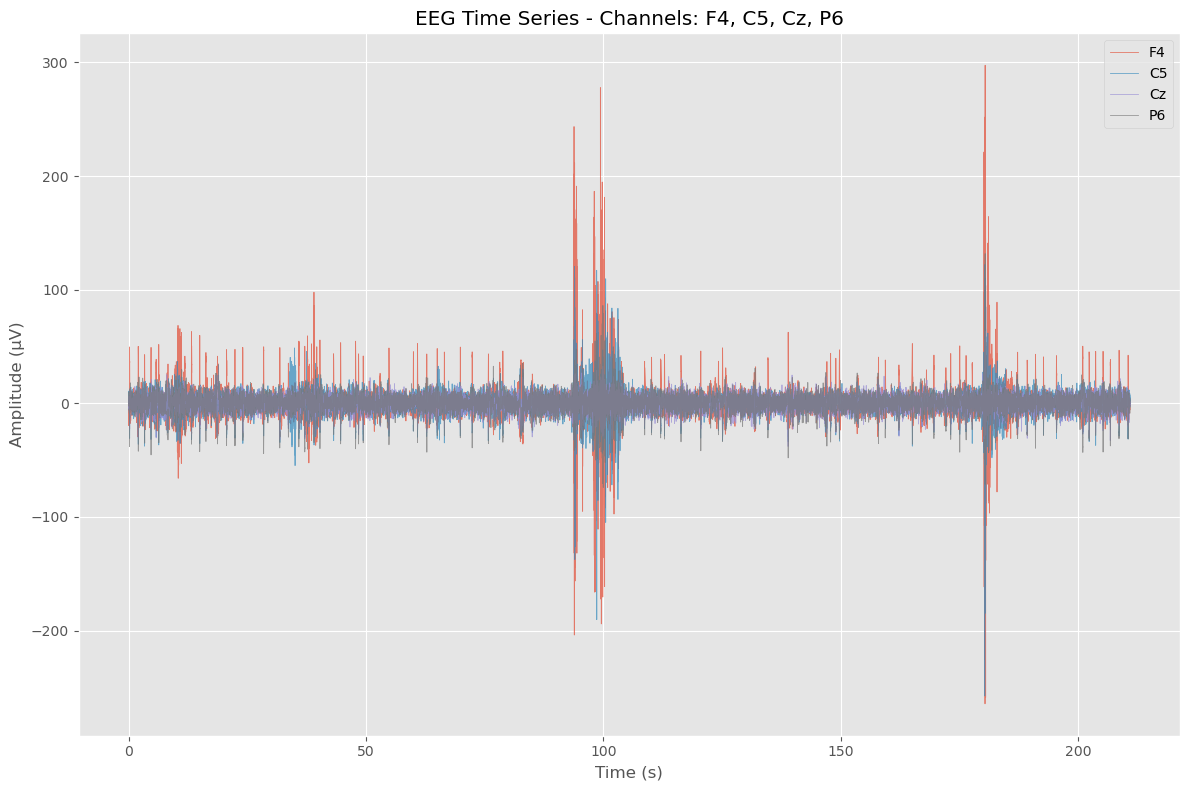

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 129.7s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 45 ICA components
    Projecting back using 63 PCA components
ICs Breakdown
Original Channels: 63. ICs: 62
Brain Components: 17, 27.42%
Other Components: 45, 72.58%
List of Brain components: [5, 9, 11, 13, 18, 19, 21, 29, 31, 32, 33, 36, 38, 41, 52, 53, 57]
Non-brain IC counts:
- eye blink: 2
- other: 8
- muscle artifact: 18
- line noise: 17
Component 0 contribution:   eeg: 53.37%
Component 1 contribution:   eeg: 7.84%
Component 2 contribution:   eeg: 4.09%
Component 3 contribution:   eeg: 3.42%
Component 4 contribution:   eeg: 2.96%
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
Using data from prelo

  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/203 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/203 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/203 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/203 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/203 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=16


  0%|          | Repairing epochs : 0/203 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Epochs rejected: 0 out of 203, 0.00%


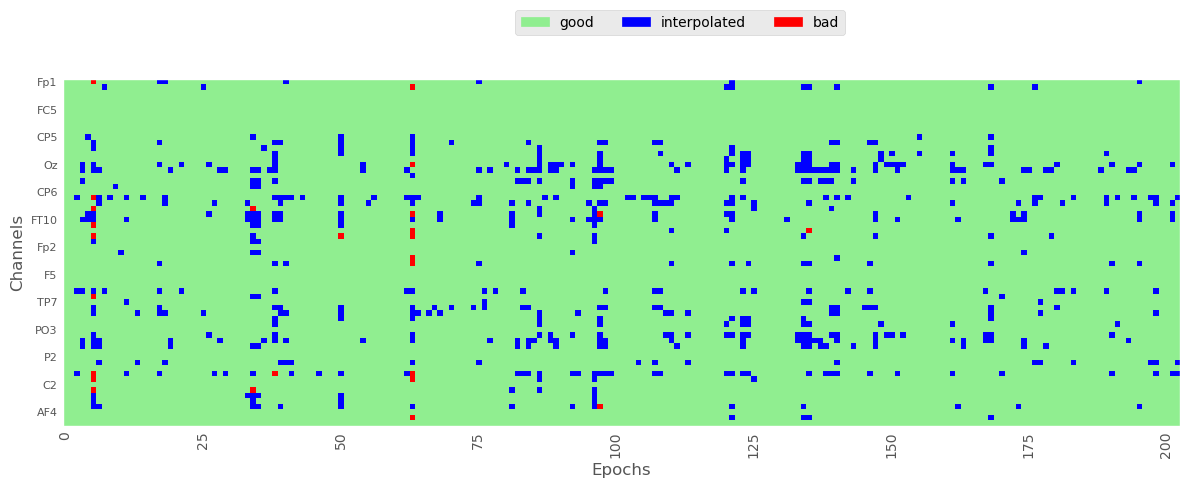

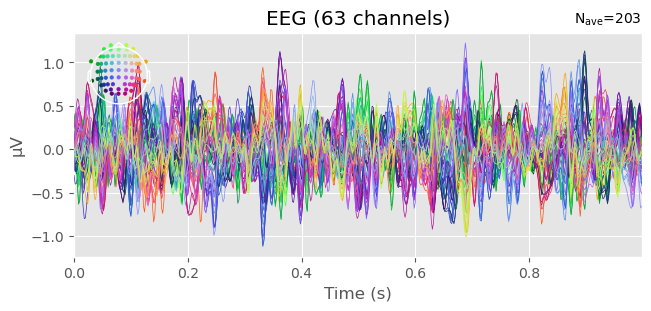

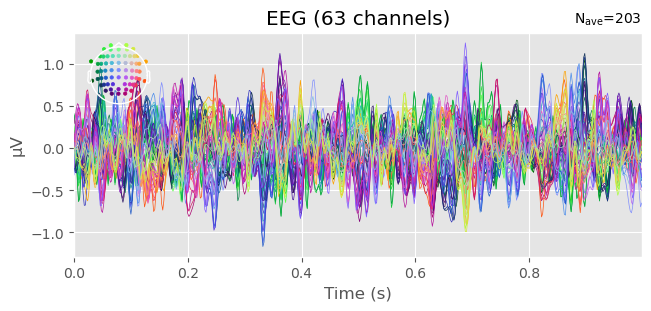

EEG Post Artifact Removal
<Epochs | 203 events (all good), 0 – 0.998 s (baseline off), ~48.9 MiB, data loaded,
 '1': 203>
Temp .... <Epochs | 203 events (all good), 0 – 0.998 s (baseline off), ~48.9 MiB, data loaded,
 '1': 203>, 
EEG_processing_quality_warning       False
channel_count                           63
ICA_components_count                    62
ICA_rejection_level               0.725806
epochs_count                           203
epoch_rejection_level                  0.0
dtype: object


In [8]:
# Run all the steps for EEG preprocessing
#

# Start Trace
summary = f'EEG Preprocessing'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- Run: {run_details['run_name']}"
summary = summary + f"\n- Preprocessing Params: {preprocess_params}"
summary = summary + f"\n- Artefact Removal Params: {artefact_params}"
print(summary)

# Initialize AutoReject
# TODO: Which initiailisation to use?
ar_model = AutoReject(cv=3, n_interpolate=[1, 4, 8, 16], 
                      consensus=[0.5, 1], 
                      thresh_method='bayesian_optimization',
                      random_state=42, n_jobs=-1, verbose=VERBOSE)
# ar_model = AutoReject(n_interpolate=[1, 2, 4], random_state=42, n_jobs=-1, verbose=VERBOSE)

# Loop through all selected subjects in the study
for idx, subject in study_subjects_df.iterrows():

    # Just sample a subset of subjects when in test mode
    if test_mode and idx not in test_subjects:
        continue

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f'Subject: {subject_id}')

    # 1. EEG Raw Dataset Load
    #
    print('---Get EEG Raw Data - FIF -----------------------------------------')
    EEG_raw_files = get_EEG_raw(study_info['dataset_path'], subject_id)
    # TODO: How to handle multiple session EEG raw files?
    EEG_raw = EEG_raw_files[0]

    save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_1_raw_files')
    save_EEG_for_subject(EEG_raw, save_folder_path, subject_id, tag='source')

    if VERBOSE:
        print(f"Description: {EEG_raw.info['description']} on {EEG_raw.info['meas_date']}")
        print(EEG_raw)
        print(EEG_raw.info)
        plot_EEG_TD(EEG_raw, test_channels)
    
    # 2. EEG Filtering & Referencing
    #
    print('---Filtering & Referencing------------------------------------------')
    EEG_filtered = perform_EEG_filtering(preprocess_params, EEG_raw)

    save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_2_cleaned_files')
    save_EEG_for_subject(EEG_filtered, save_folder_path, subject_id, tag='filtered')

    if VERBOSE:
        plot_EEG_TD(EEG_filtered, test_channels)

    # 3. Artefact Removal with ICA etc
    #
    print('---Artefact Removal - ICA ------------------------------------------')
    artefact_results, EEG_cleaned = perform_artefact_removal(artefact_params, EEG_filtered)

    save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_2_cleaned_files')
    save_EEG_for_subject(EEG_cleaned, save_folder_path, subject_id, tag='preprocessed', epoched=True)

    if VERBOSE:
        # TODO: Any need to summarise or retain results?
        # TODO: Correct plot for Epoched data
        # plot_EEG_TD(EEG_cleaned, test_channels)
        print(f'Temp .... {EEG_cleaned}, \n{artefact_results}')



# Run: 1b EEG Feature Extraction

# Run: 1c EEG Results Collation